## **1. Vanilla GAN**
*     Reference. https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py, https://github.com/Yangyangii/pytorch-practice/blob/master/GAN.ipynb, https://arxiv.org/pdf/1406.2661

In [2]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import numpy as np
import datetime
import os
import sys
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [3]:
MODEL_NAME = 'GAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE) # 100개의 random noise 생성
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy() # cpu로 이동시키고 Numpy배열로 변환
    img = np.zeros([280, 280]) # 100 개 이미지 담을 큰 이미지 초기화
    for j in range(10): # 10x10 이미지 arrange
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [6]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

In [7]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )

    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [8]:
n_noise = 100

In [9]:
#Device setting
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

In [10]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

In [11]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16009456.97it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 496236.08it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4474538.46it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8624051.05it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [12]:
batch_size = 64
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [13]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [14]:
max_epoch = 50 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [15]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [16]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [17]:
for epoch in range(max_epoch): #max_epoch만큼의 epoch 동안 학습 반복
    for idx, (images, _) in enumerate(data_loader): # data_loader 사용하여 batch 단위로 데이터 불러옴
                                                    # 현재 배치의 인덱스와 데이터를 반환
        # Training Discriminator
        x = images.to(DEVICE) # real image 'x'를 device에 이동시킨 후 Disciminator에 통과시켜 결과 얻기
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels) #loss 계산

        z = torch.randn(batch_size, n_noise).to(DEVICE) #random noise vector 'z' 생성
        z_outputs = D(G(z)) # Generator를 통해 가짜 이미지 생성 # D에 통과시켜 결과 얻
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step() #D_loss를 계산한 후 backpropagation하여 disciminator update

        if step % n_critic == 0: #discriminator 여러 번 훈련 후 한 번 Generator 훈련('n_critic'간격으로)
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE) #새로운 random noise vector 'z' 생성한 후 이를 통해 가짜 이미지 생성해 D에 통과시켜 결과 얻기
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()

#훈련 과정 출력 및 샘플 이미지 저
        if step % 500 == 0: #step이 500의 배수일 때 마다 출력
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0: #step이 1000의 배수일 때 마다 Generator를 평가모드로 전환
            G.eval()
            img = get_sample_image(G, n_noise) #sample image 생성하여 파일로 저장
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train() # 다시 학습모드로 전환
        step += 1 # 'step' 변수 증가시켜 반복

Epoch: 0/50, Step: 0, D Loss: 1.3973146677017212, G Loss: 0.6735372543334961
Epoch: 0/50, Step: 500, D Loss: 1.3343563079833984, G Loss: 0.8114367127418518
Epoch: 1/50, Step: 1000, D Loss: 1.3095723390579224, G Loss: 0.5967708230018616
Epoch: 1/50, Step: 1500, D Loss: 1.2015992403030396, G Loss: 0.9106911420822144
Epoch: 2/50, Step: 2000, D Loss: 1.2416448593139648, G Loss: 0.6953891515731812
Epoch: 2/50, Step: 2500, D Loss: 1.220353364944458, G Loss: 0.8491253852844238
Epoch: 3/50, Step: 3000, D Loss: 1.1649423837661743, G Loss: 0.787266731262207
Epoch: 3/50, Step: 3500, D Loss: 1.185737133026123, G Loss: 1.1284785270690918
Epoch: 4/50, Step: 4000, D Loss: 1.291360855102539, G Loss: 0.5547462105751038
Epoch: 4/50, Step: 4500, D Loss: 1.2668280601501465, G Loss: 0.9814143180847168
Epoch: 5/50, Step: 5000, D Loss: 1.1928865909576416, G Loss: 0.9058470726013184
Epoch: 5/50, Step: 5500, D Loss: 1.3159886598587036, G Loss: 1.1992042064666748
Epoch: 6/50, Step: 6000, D Loss: 1.2222372293472

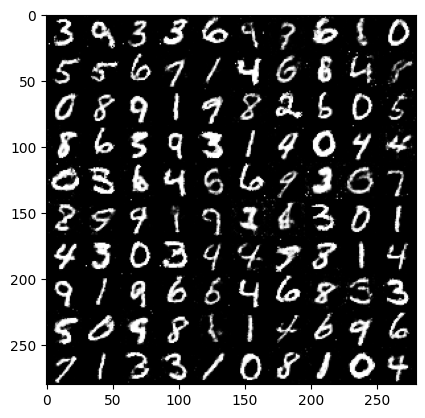

In [18]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [19]:
# Saving params
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')